# Uniform Wass

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [1]:
import tensorflow as tf

import tensorflow_probability as tfp

In [2]:
import os, sys, subprocess
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

import ot

import matplotlib.pylab as pl

/home/bobby/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/bobby/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/bobby/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/home/bobby/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/bobby/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/hom

In [3]:
sys.path.append('../')
sys.path.append('../..')
from src.generate_data import generate_data_from_signal, generate_grouped_data, generate_series, sample_prior, generate_theta, generate_alternate_series
from src.posterior_samplers import posterior_sample, wasserstein_coefs, normal_sampler, make_1D_trunc_gauss, Bary_generator_unif, Bary_list_sampler, Bary_generator_gauss

## Generate Data

In [4]:
# Params
n=4800
m=40
sig=1
tau=1
alpha=1
beta = 1
num_coef = 1000

In [5]:
signal = generate_theta(num_coeff=num_coef)

In [6]:
observations = generate_grouped_data(signal, n=n, sig=sig, m=m)

In [7]:
observations = np.load('outfile.npy')

In [8]:
def list_of_arrary_to_df(list_of_array, 
                         type_col='Simulated', 
                         list_index = 'index',
                         inter_list_index='observation'):
    
    all_obs = pd.DataFrame.from_records(list_of_array)
    stacked_obs = all_obs.reset_index().set_index('index').stack().reset_index()

    stacked_obs.columns = [inter_list_index, list_index, 'Value']

    stacked_obs['type'] = type_col
    
    return stacked_obs

sort the thetas by component

In [9]:
list_of_theta = [observations[i] for i in range(len(observations))]
stacked_theta = list_of_arrary_to_df(list_of_theta, list_index = 'component')
theta_observations = np.array([stacked_theta.loc[stacked_theta['component'] == i,'Value'] for i in range(num_coef)])

In [10]:
list_of_obs = [Y for X,Y in [generate_alternate_series(observations[i]) for i in range(len(observations))]]

In [11]:
stacked_obs = list_of_arrary_to_df(list_of_obs, list_index='time_index')

In [12]:
signal_df = pd.DataFrame({'Value': generate_alternate_series(signal)[1], 'time_index' : [i for i in np.arange(len(signal))]})
signal_df['type'] = 'True'

## Visualise the data

In [13]:
plot_df = pd.concat([stacked_obs[['time_index','Value', 'type']], signal_df], sort=True).reset_index()

In [14]:
plot_df['time'] = plot_df['time_index']/num_coef

## Session

ps_hosts=["localhost:2222"]
worker_hosts=["localhost:2223","localhost:2224"]
cluster = tf.train.ClusterSpec({"ps": ps_hosts, "worker": worker_hosts})

server = tf.train.Server(cluster,
                             job_name='ps',
                             task_index=0)

# Uniform prior barycenter visualisation

In [16]:
a = theta_observations[0]
n_bins=100

n_sig=4800

In [59]:
hist_array= np.empty((0,n_bins))
for num in a:
    temp_hist = make_1D_trunc_gauss(n=n_bins, lb=-0.5 , n_sig = n_sig, ub = 0.5, mu=num, sig = sig)
    hist_array = np.vstack((hist_array, temp_hist))
#hist_array = hist_array[1:,]
A = hist_array.T

In [60]:
n_distributions = A.shape[1]

In [61]:
x = np.arange(-0.5,0.5,1/n_bins, dtype=np.float64)

x = np.resize(x,(100,1))

M = ot.utils.dist(x1 = x )

M /= M.max()

# wasserstein
reg = 1e-2
bary_wass = ot.bregman.barycenter(A, M, reg, weights=None)

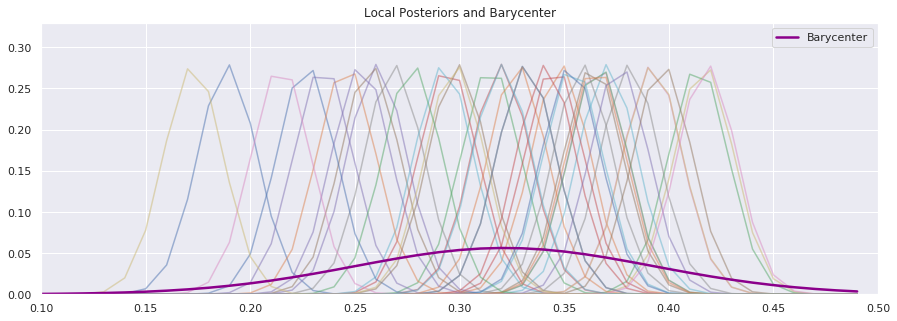

In [97]:
pl.figure( figsize=(15, 5))
for i in range(n_distributions):
    pl.plot(x, A[:, i], alpha = 0.5)
pl.title('Local Posteriors and Barycenter')
pl.plot(x, bary_wass, 'g', label='Barycenter',linewidth=2.5, color='darkmagenta')
pl.axis((0.1,0.5,0,0.33))
pl.legend()
pl.savefig('Barycenter.pdf')


## Sequential graph

In [113]:
wass_bary_temp = [wasserstein_coefs(observations[i], n, sig, alpha) for i in range(m)] 
wass_bary_coefs = np.mean(wass_bary_temp,0)
wass_bary_sample = normal_sampler(wass_bary_coefs[0,], wass_bary_coefs[1,])
wass_centred_mean = [np.square(wass_bary_temp[i][0]-wass_bary_coefs[0]) for i in range(m)]
kl_additional_variance = np.mean(wass_centred_mean,0)
kl_bary_sample = normal_sampler(wass_bary_coefs[0,], wass_bary_coefs[1,] + kl_additional_variance)

/home/bobby/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/bobby/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/bobby/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/bobby/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/bobby/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is de

## Entropic Wasserstein results unif 1e-2

In [109]:
barys= Bary_generator_unif(beta=1,n=4800,n_bins=100,n_coef=1000,reg=1e-2,sig=1,theta=theta_observations)

nsim = 2000
entro_wass_results = [None] * nsim
break_div = np.floor_divide(nsim,10)
for i in range(nsim):
    entro_wass_results[i] = Bary_list_sampler(barys, beta = 1, n_bins = 100)

    if i % break_div == 0:
        print("Iteration {0} of {1}".format(i, nsim))

Iteration 0 of 2000
Iteration 200 of 2000
Iteration 400 of 2000
Iteration 600 of 2000
Iteration 800 of 2000
Iteration 1000 of 2000
Iteration 1200 of 2000
Iteration 1400 of 2000
Iteration 1600 of 2000
Iteration 1800 of 2000


/home/bobby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


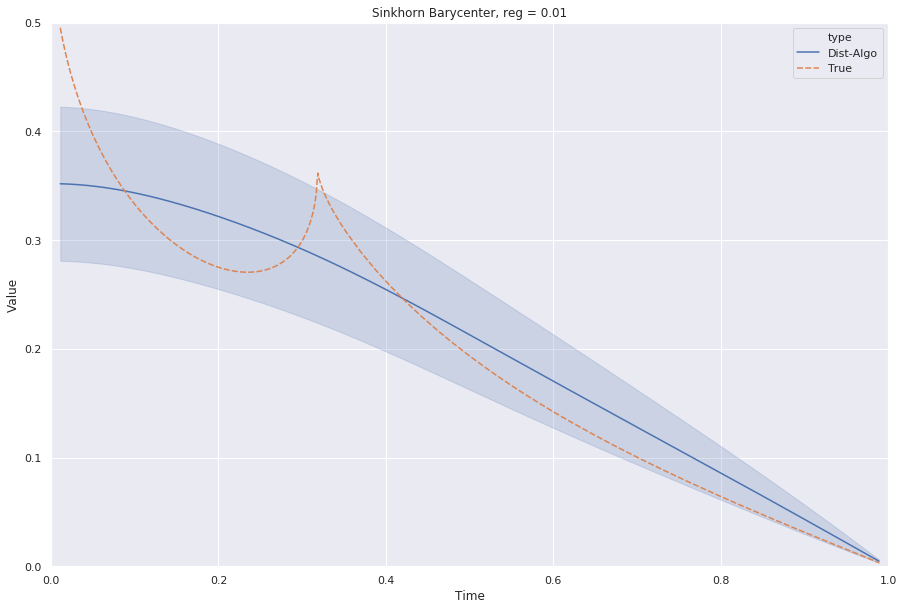

In [110]:
list_of_post = [Y for X,Y in [generate_alternate_series(entro_wass_results[i]) for i in range(len(entro_wass_results))]]
stacked_post = list_of_arrary_to_df(list_of_post, list_index='time_index', type_col='Dist-Algo')

plot_df2 = pd.concat([stacked_post[['time_index','Value', 'type']], signal_df], sort=True)\
.reset_index()
plot_df3 = plot_df2.loc[(plot_df2.time_index > 10) & (plot_df2.time_index <990),:]
plot_df3['Time'] = plot_df3['time_index']/num_coef
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)

# Plot the responses for different events and regions
sns.lineplot(x="Time", y='Value', hue='type', data=plot_df3, ax=ax, style='type', ci='sd')
plt.axis((0,1,0,0.5))
plt.title('Sinkhorn Barycenter, reg = 0.01')
plt.savefig('Sinkhorn1e2.pdf')

## Entropic regularisation unif, reg=1e-1

In [111]:
barys= Bary_generator_unif(beta=1,n=4800,n_bins=100,n_coef=1000,reg=1e-1,sig=1,theta=theta_observations)

nsim = 2000
entro_wass_results = [None] * nsim
break_div = np.floor_divide(nsim,10)
for i in range(nsim):
    entro_wass_results[i] = Bary_list_sampler(barys, beta = 1, n_bins = 100)

    if i % break_div == 0:
        print("Iteration {0} of {1}".format(i, nsim))

Iteration 0 of 2000
Iteration 200 of 2000
Iteration 400 of 2000
Iteration 600 of 2000
Iteration 800 of 2000
Iteration 1000 of 2000
Iteration 1200 of 2000
Iteration 1400 of 2000
Iteration 1600 of 2000
Iteration 1800 of 2000


In [123]:
np.array([1,2,3]).min()

1

/home/bobby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


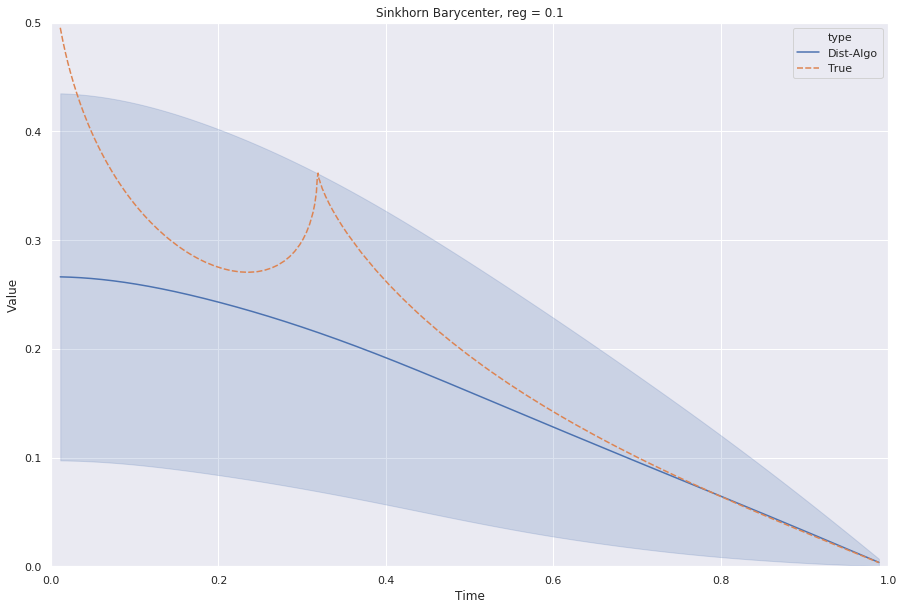

In [112]:
list_of_post = [Y for X,Y in [generate_alternate_series(entro_wass_results[i]) for i in range(len(entro_wass_results))]]
stacked_post = list_of_arrary_to_df(list_of_post, list_index='time_index', type_col='Dist-Algo')

plot_df2 = pd.concat([stacked_post[['time_index','Value', 'type']], signal_df], sort=True)\
.reset_index()
plot_df3 = plot_df2.loc[(plot_df2.time_index > 10) & (plot_df2.time_index <990),:]
plot_df3['Time'] = plot_df3['time_index']/num_coef
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)

# Plot the responses for different events and regions
sns.lineplot(x="Time", y='Value', hue='type', data=plot_df3, ax=ax, style='type', ci='sd')
plt.axis((0,1,0,0.5))
plt.title('Sinkhorn Barycenter, reg = 0.1')
plt.savefig('Sinkhorn1e1.pdf')

## Entropic Regularisation gaussian, reg = 1e-2

In [15]:
barys= Bary_generator_gauss(beta=1,n=4800,n_bins=100,n_coef=1000,reg=1e-2,sig=1,theta=theta_observations)

nsim = 2000
entro_wass_results = [None] * nsim
break_div = np.floor_divide(nsim,10)
for i in range(nsim):
    entro_wass_results[i] = Bary_list_sampler(barys, beta = 1, n_bins = 100)

    if i % break_div == 0:
        print("Iteration {0} of {1}".format(i, nsim))

Iteration 0 of 2000
Iteration 200 of 2000
Iteration 400 of 2000
Iteration 600 of 2000
Iteration 800 of 2000
Iteration 1000 of 2000
Iteration 1200 of 2000
Iteration 1400 of 2000
Iteration 1600 of 2000
Iteration 1800 of 2000


/home/bobby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


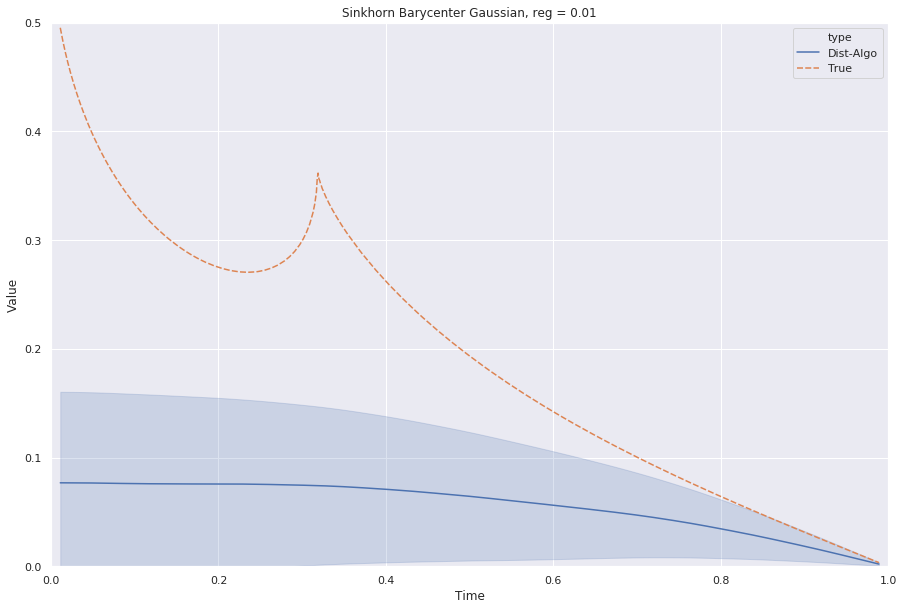

In [16]:
list_of_post = [Y for X,Y in [generate_alternate_series(entro_wass_results[i]) for i in range(len(entro_wass_results))]]
stacked_post = list_of_arrary_to_df(list_of_post, list_index='time_index', type_col='Dist-Algo')

plot_df2 = pd.concat([stacked_post[['time_index','Value', 'type']], signal_df], sort=True)\
.reset_index()
plot_df3 = plot_df2.loc[(plot_df2.time_index > 10) & (plot_df2.time_index <990),:]
plot_df3['Time'] = plot_df3['time_index']/num_coef
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)

# Plot the responses for different events and regions
sns.lineplot(x="Time", y='Value', hue='type', data=plot_df3, ax=ax, style='type', ci='sd')
plt.axis((0,1,0,0.5))
plt.title('Sinkhorn Barycenter Gaussian, reg = 0.01')
plt.savefig('Sinkhorngauss1e2.pdf')

## Entropic gauss 1e-1

In [17]:
barys= Bary_generator_gauss(beta=1,n=4800,n_bins=100,n_coef=1000,reg=1e-1,sig=1,theta=theta_observations)

nsim = 2000
entro_wass_results = [None] * nsim
break_div = np.floor_divide(nsim,10)
for i in range(nsim):
    entro_wass_results[i] = Bary_list_sampler(barys, beta = 1, n_bins = 100)

    if i % break_div == 0:
        print("Iteration {0} of {1}".format(i, nsim))

Iteration 0 of 2000
Iteration 200 of 2000
Iteration 400 of 2000
Iteration 600 of 2000
Iteration 800 of 2000
Iteration 1000 of 2000
Iteration 1200 of 2000
Iteration 1400 of 2000
Iteration 1600 of 2000


KeyboardInterrupt: 

In [ ]:
list_of_post = [Y for X,Y in [generate_alternate_series(entro_wass_results[i]) for i in range(len(entro_wass_results))]]
stacked_post = list_of_arrary_to_df(list_of_post, list_index='time_index', type_col='Dist-Algo')

plot_df2 = pd.concat([stacked_post[['time_index','Value', 'type']], signal_df], sort=True)\
.reset_index()
plot_df3 = plot_df2.loc[(plot_df2.time_index > 10) & (plot_df2.time_index <990),:]
plot_df3['Time'] = plot_df3['time_index']/num_coef
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)

# Plot the responses for different events and regions
sns.lineplot(x="Time", y='Value', hue='type', data=plot_df3, ax=ax, style='type', ci='sd')
plt.axis((0,1,0,0.5))
plt.title('Sinkhorn Barycenter Gaussian, reg = 0.1')
plt.savefig('Sinkhorngauss1e1.pdf')

## Wasserstein results

In [117]:
nsim = 2000
wass_results = [None] * nsim
break_div = np.floor_divide(nsim,10)
with tf.Session() as sess: 
    for i in range(nsim):
        wass_results[i] = sess.run(wass_bary_sample)
        
        if i % break_div == 0:
            print("Iteration {0} of {1}".format(i, nsim))

Iteration 0 of 2000
Iteration 200 of 2000
Iteration 400 of 2000
Iteration 600 of 2000
Iteration 800 of 2000
Iteration 1000 of 2000
Iteration 1200 of 2000
Iteration 1400 of 2000
Iteration 1600 of 2000
Iteration 1800 of 2000


### Look at Wasserstein results

/home/bobby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


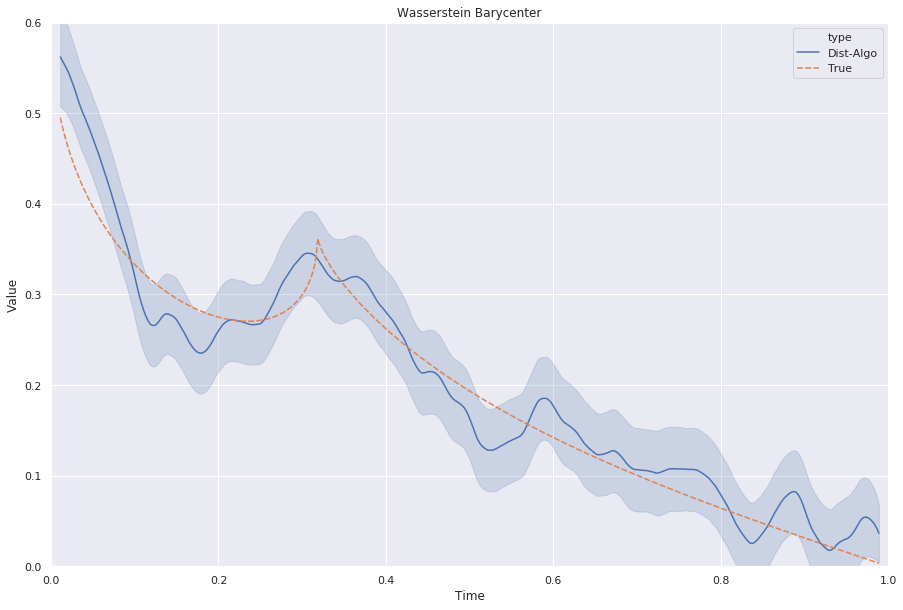

In [118]:
list_of_post = [Y for X,Y in [generate_alternate_series(wass_results[i]) for i in range(len(wass_results))]]
stacked_post = list_of_arrary_to_df(list_of_post, list_index='time_index', type_col='Dist-Algo')

plot_df2 = pd.concat([stacked_post[['time_index','Value', 'type']], signal_df], sort=True)\
.reset_index()
plot_df3 = plot_df2.loc[(plot_df2.time_index > 10) & (plot_df2.time_index <990),:]
plot_df3['Time'] = plot_df3['time_index']/num_coef
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)

# Plot the responses for different events and regions
sns.lineplot(x="Time", y='Value', hue='type', data=plot_df3, ax=ax, style='type', ci='sd')
plt.axis((0,1,0,0.6))
plt.title('Wasserstein Barycenter')
plt.savefig('Wasserstein.pdf')

## Results KL- barycenter

In [119]:
nsim = 2000
kl_results = [None] * nsim
break_div = np.floor_divide(nsim,10)
with tf.Session() as sess: 
    for i in range(nsim):
        kl_results[i] = sess.run(kl_bary_sample)
        
        if i % break_div == 0:
            print("Iteration {0} of {1}".format(i, nsim))

Iteration 0 of 2000
Iteration 200 of 2000
Iteration 400 of 2000
Iteration 600 of 2000
Iteration 800 of 2000
Iteration 1000 of 2000
Iteration 1200 of 2000
Iteration 1400 of 2000
Iteration 1600 of 2000
Iteration 1800 of 2000


## KL Barycenter plot

/home/bobby/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


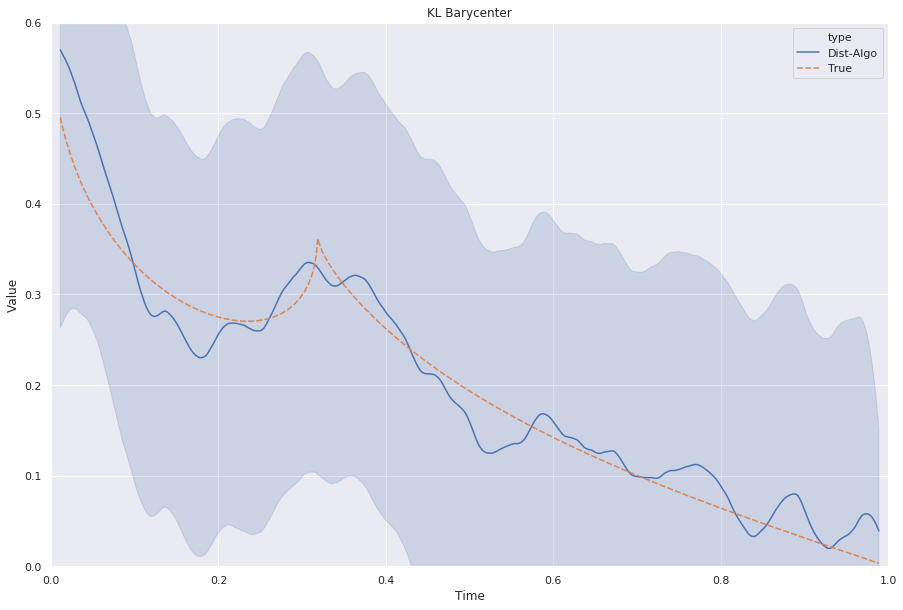

In [121]:
list_of_post = [Y for X,Y in [generate_alternate_series(kl_results[i]) for i in range(len(kl_results))]]
stacked_post = list_of_arrary_to_df(list_of_post, list_index='time_index', type_col='Dist-Algo')

plot_df2 = pd.concat([stacked_post[['time_index','Value', 'type']], signal_df], sort=True)\
.reset_index()
plot_df3 = plot_df2.loc[(plot_df2.time_index > 10) & (plot_df2.time_index <990),:]
plot_df3['Time'] = plot_df3['time_index']/num_coef
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)

# Plot the responses for different events and regions
sns.lineplot(x="Time", y='Value', hue='type', data=plot_df3, ax=ax, style='type', ci='sd')
plt.axis((0,1,0,0.6))
plt.title('KL Barycenter')
plt.savefig('KL.pdf')

## Build Distributed graph

First set up worker compute nodes for tasks 0,1 etc. using commands below from scripts directory in separate processes i.e. from separate terminals or as background processes:

- python create_worker.py --ps_hosts=localhost:2222 --worker_hosts=localhost:2223,localhost:2224 --job_name=worker --task_index=0 &
- python create_worker.py --ps_hosts=localhost:2222 --worker_hosts=localhost:2223,localhost:2224 --job_name=worker --task_index=1 &

Or use bash script from the scripts directory:
- sh -x bash.sh

In [35]:
ps_hosts=["localhost:2222"]
worker_hosts=["localhost:2223","localhost:2224"]
cluster = tf.train.ClusterSpec({"ps": ps_hosts, "worker": worker_hosts})

In [36]:
server = tf.train.Server(cluster,
                             job_name='ps',
                             task_index=0)

UnknownError: Could not start gRPC server

In [37]:
with tf.device("/job:worker/task:0"):
    posterior1 = posterior_sample(observations[0], n, m, sig, tau, alpha)
    
with tf.device("/job:worker/task:1"):
    posterior2 = posterior_sample(observations[1], n, m, sig, tau, alpha)

    samp = (posterior1 + posterior2)/2
    

/homes/bhe/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/homes/bhe/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/homes/bhe/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/homes/bhe/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/homes/bhe/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is depreca

In [18]:
nsim = 2000
results = [None] * nsim
break_div = np.floor_divide(nsim,10)
with tf.Session("grpc://localhost:2223") as sess: 
    for i in range(nsim):
        results[i] = sess.run(samp)
        
        if i % break_div == 0:
            print("Iteration {0} of {1}".format(i, nsim))

Iteration 0 of 2000
Iteration 200 of 2000
Iteration 400 of 2000
Iteration 600 of 2000
Iteration 800 of 2000
Iteration 1000 of 2000
Iteration 1200 of 2000
Iteration 1400 of 2000
Iteration 1600 of 2000
Iteration 1800 of 2000


### Look at results

In [ ]:
list_of_post = [Y for X,Y in [generate_series(results[i]) for i in range(len(results))]]
stacked_post = list_of_arrary_to_df(list_of_post, list_index='time_index', type_col='Dist-Algo')

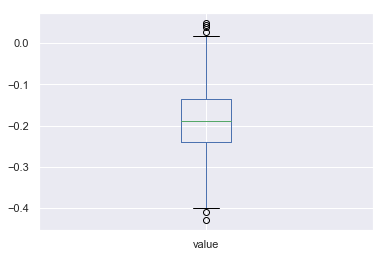

In [78]:
stacked_post.loc[stacked_post.time_index == 50,['value']].boxplot()

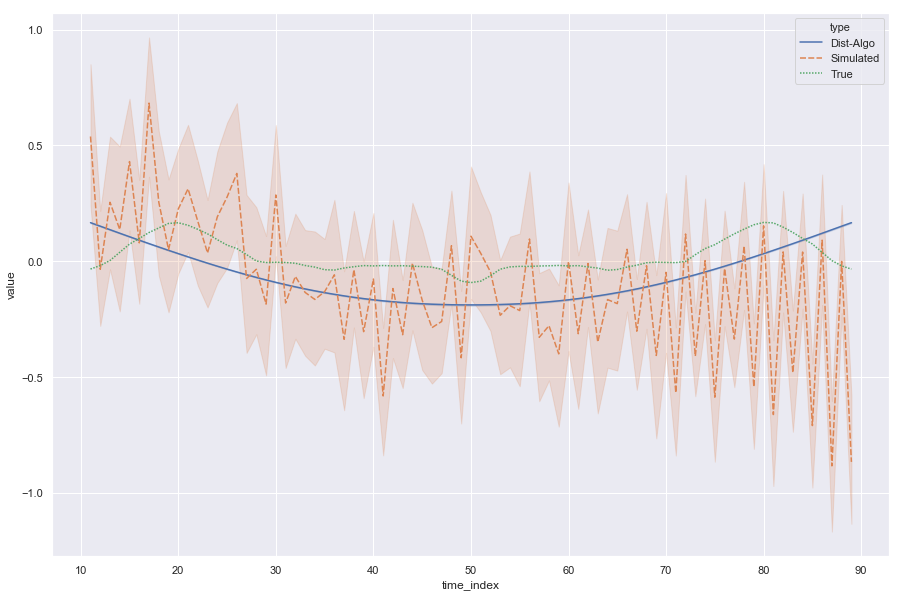

In [74]:
plot_df2 = pd.concat([stacked_post[['time_index','value', 'type']], plot_df], sort=True)\
.reset_index()

rview = (plot_df2.time_index > 10) & (plot_df2.time_index <90)# & (plot_df2.type=='Dist-Algo')
plot_df3 = plot_df2.loc[rview,:]

a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)

# Plot the responses for different events and regions
sns.lineplot(x="time_index", y='value', hue='type', data=plot_df3, ax=ax, style='type', err_style = 'band')
